In [1]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 58.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')


Mounted at /content/drive


### **1. Cargar el dataset y EDA**

                               Title  \
0              Mi Lugar Favorito!!!!   
1  lugares interesantes para visitar   
2             No es el mismo Dreams    
3  un buen panorama cerca de CancÃºn   
4                           El mejor   

                                              Review  Polarity          Town  \
0  Excelente lugar para comer y pasar una buena n...       5.0      Sayulita   
1  andar mucho, así que un poco difícil para pers...       4.0         Tulum   
2  Es nuestra cuarta visita a Dreams Tulum, elegi...       3.0         Tulum   
3  Estando en CancÃºn, fuimos al puerto y tomamos...       4.0  Isla_Mujeres   
4  Es un lugar antiguo y por eso me encanto tiene...       5.0     Patzcuaro   

        Region        Type  
0      Nayarit  Restaurant  
1  QuintanaRoo  Attractive  
2  QuintanaRoo       Hotel  
3  QuintanaRoo  Attractive  
4    Michoacan       Hotel  


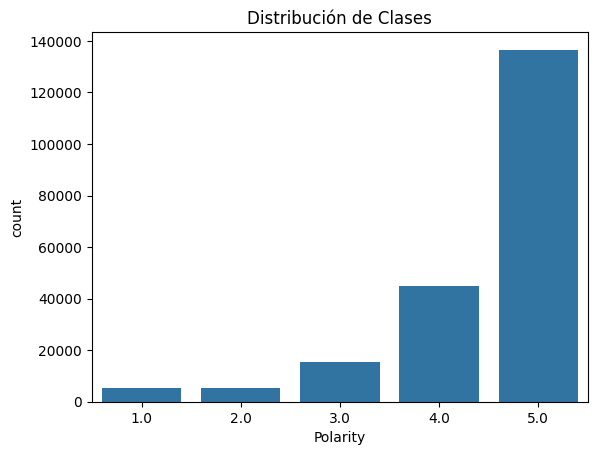

Nulos:
 Title       2
Review      0
Polarity    0
Town        0
Region      0
Type        0
dtype: int64
Duplicados: 178


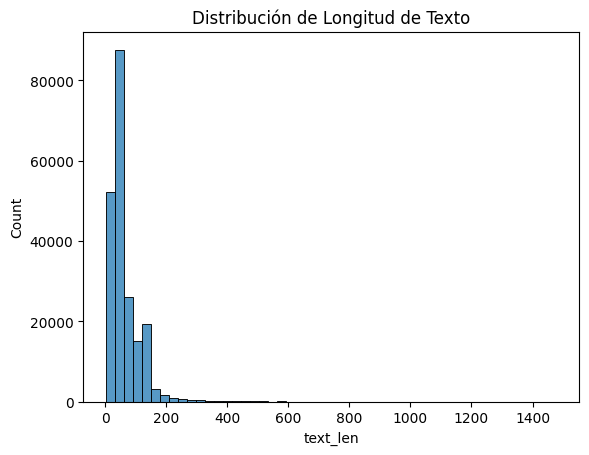

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
path = "/content/drive/My Drive/IA/Rest-Mex_2025_train.csv"
df = pd.read_csv(path)

# Ver primeras filas
print(df.head())

# Ver distribución de clases
sns.countplot(x="Polarity", data=df)
plt.title("Distribución de Clases")
plt.show()

# Verificar nulos y duplicados
print("Nulos:\n", df.isnull().sum())
print("Duplicados:", df.duplicated().sum())

# Ver longitud de las reseñas
df["text_len"] = df["Review"].apply(lambda x: len(str(x).split()))
sns.histplot(df["text_len"], bins=50)
plt.title("Distribución de Longitud de Texto")
plt.show()


### **2. Balancear (undersampling) y recortar**

In [4]:
from sklearn.utils import resample

# Balancear clases (undersampling)
dfs = []
min_size = df['Polarity'].value_counts().min()

for label in df['Polarity'].unique():
    df_label = df[df['Polarity'] == label]
    df_label_resampled = resample(df_label, replace=False, n_samples=min_size, random_state=42)
    dfs.append(df_label_resampled)

df_balanced = pd.concat(dfs)

# Reset index
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Contar cuántos ejemplos hay por clase después del balanceo
print(df_balanced['Polarity'].value_counts())

Polarity
4.0    5441
3.0    5441
5.0    5441
1.0    5441
2.0    5441
Name: count, dtype: int64


### **3. Preprocesamiento clásico (stopwords, lematización)**

In [5]:
import nltk
import spacy
import re

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

nlp = spacy.load("es_core_news_sm")

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Eliminar signos de puntuación
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct and not token.is_space]
    return " ".join(tokens)

df_balanced["clean_text"] = df_balanced["Review"].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **4. Extraer embeddings con BERT**

# **Nuevo paso 4**

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo y tokenizer
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model.to(device)
model.eval()

# Función para procesar textos en lotes y extraer embeddings [CLS]
def get_batch_embeddings(texts, tokenizer, model, device, batch_size=32, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenizar en batch
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True,
                           padding=True, max_length=max_length)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Extraer embeddings con BERT
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            all_embeddings.append(cls_embeddings.cpu())

    # Concatenar todos los embeddings
    return torch.cat(all_embeddings, dim=0).numpy()

# Aplicar la función optimizada
texts = df_balanced["clean_text"].tolist()
X = get_batch_embeddings(texts, tokenizer, model, device)
y = df_balanced["Polarity"].values


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/851 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 851/851 [02:39<00:00,  5.32it/s]


### **5. Entrenar SVM con embeddings**

# **Nuevo paso 5**

Reporte de clasificación:
              precision    recall  f1-score   support

         1.0       0.53      0.57      0.55      1088
         2.0       0.36      0.35      0.35      1088
         3.0       0.36      0.35      0.36      1088
         4.0       0.40      0.39      0.40      1089
         5.0       0.59      0.59      0.59      1088

    accuracy                           0.45      5441
   macro avg       0.45      0.45      0.45      5441
weighted avg       0.45      0.45      0.45      5441



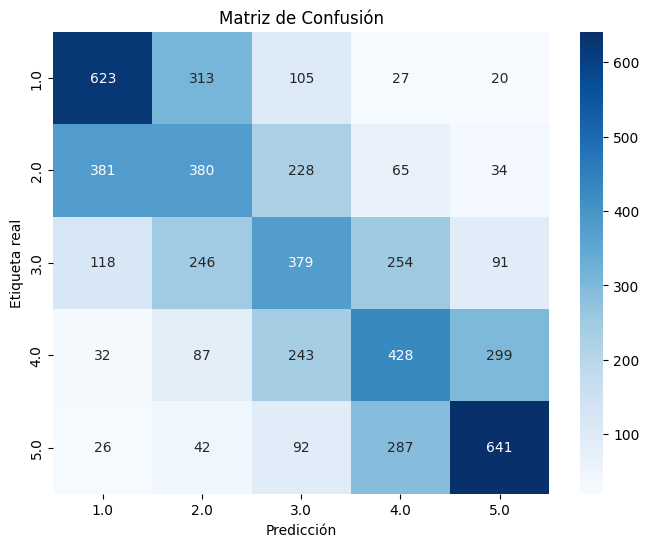

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar el modelo SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Imprimir el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.show()


### **Paso 6: Guardar el modelo entrenado en tu Google Drive**

In [ ]:
# Montar Google Drive (si aún no lo has hecho)
from google.colab import drive
drive.mount('/content/drive')

# Guardar el modelo con joblib
import joblib

ruta_modelo = "/content/drive/MyDrive/IA/svm_bert_model.joblib"
joblib.dump(svm_model, ruta_modelo)

print(f"Modelo guardado en: {ruta_modelo}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo guardado en: /content/drive/MyDrive/IA/svm_bert_model.joblib


### **Paso 7: Clasificar nuevas frases**

In [ ]:
# Cargar modelo guardado
import joblib
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Cargar modelo SVM desde Drive
svm_model = joblib.load("/content/drive/MyDrive/IA/svm_bert_model.joblib")

# Cargar tokenizer y modelo BERT
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model.eval()

# Función para obtener el embedding de BERT
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS]

# Frases nuevas para clasificar
nuevas_frases = [
    "La comida estaba deliciosa y el servicio fue excelente.",
    "Fue una experiencia terrible, no volveré jamás.",
    "Regular, no fue ni buena ni mala.",
]

# Obtener embeddings de las frases nuevas
embeddings_nuevas = np.array([get_bert_embedding(frase) for frase in nuevas_frases])

# Clasificar con SVM
predicciones = svm_model.predict(embeddings_nuevas)

# Mostrar resultados
for frase, pred in zip(nuevas_frases, predicciones):
    print(f"Frase: '{frase}' => Predicción: {pred}")


Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frase: 'La comida estaba deliciosa y el servicio fue excelente.' => Predicción: 4.0
Frase: 'Fue una experiencia terrible, no volveré jamás.' => Predicción: 2.0
Frase: 'Regular, no fue ni buena ni mala.' => Predicción: 2.0
